# [IAPR 2018:][iapr2018] Lab 2 ‒  Object description

**Author:** Ibrahim Youssef, Bryce Burgess  
**Due date:** 04.05.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

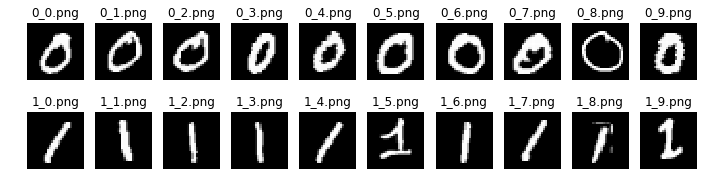

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

We began our investigation by extracting the Fourier descriptors as features for the images. Fourier descriptors are a very interesting feature because, when selected correctly, they can allow us to correctly identify images despite translations, rotations, and even scaling.

The first step in extracting the Fourier descriptors was to perform a series of pre-processing operations on the images. We began by applying a median filter to the grayscale image in order to smoothen out the images, filter out some noise, and reduce sharp intensity changes. We then applied thresholding in order to obtain a binary image for each sample. With this binary image, we then performed binary closing on the image. Binary closing was implemented by performing a dilation followed by an erosion operation.

In order to correctly perform the Discrete Fourier Transform (DFT), the coordinates of every pixel along a contour were first represented as a set of complex numbers $ u_i = x_i +jy_i $. With these complex signals $u_i$, we were then able to compute the DFTs for each contour. The resulting complex values obtained from this operation are the set of Fourier descriptors that describe an image. It was from these set of Fourier descriptors that we obtained our image features.

$f_i = \sum_{k=0}^{N-1}{u_k e^{\frac{-j2\pi k l}{N}}}$, where N is the number of points along the contour.

In order to ensure that our features were translation invariant, we discarded the first Fourier descriptor $f_0$. Removing this term effectively filtered out the DC component of our complex signal. We also wanted to make sure that the features performed the same when the images were rotated. In order to achieve this, we considered only the *magnitudes* of the Fourier descriptors $|f_i| = \sqrt{x_i^2 + y_i^2} $. 

Finally, the 2 features that were selected were $|f_1|$ and $|f_3|$. As we can see, this yielded quite good results. We observe a distinct separation between the blue-labeled points representing the "0"'s, and the red-labeled points representing the "1"'s. With a simple straight line, we can partition the plane with all the "0"'s on one side, and all the "1"'s on the other.






In [23]:
import numpy as np
from scipy import ndimage as ndi
from skimage.measure import find_contours
from skimage.filters import threshold_mean
from skimage.filters import median
from skimage.morphology import binary_dilation
from skimage.morphology import binary_erosion

#############################################
# Define a function to detect the contour of any given image 
#############################################

def detect_contour(image):
    
    # Median filter the  images to filter out noise and smoothen the image.
    image = median(image)
    
    # Find a threshold for the zero and one images
    thresh = threshold_mean(image)
    
    # Create binary images for each picture
    binary_image = image > thresh
     
    # Perform binary closing on the image, which is a dilation followed by an erosion operation
    binary_image = binary_dilation(binary_image)
    binary_image = binary_erosion(binary_image)
    
    # Find the contours of the images. Contours are represented by an array of coordinates (x, y)
    contour = find_contours(binary_image, 0)[0]
    
    return contour

#############################################
# Define a function to extract the fourier descriptions for a list of images. 
#############################################

def extract_fourier_descriptors(images, names, descriptors_to_extract, plot_contours):
    
    # Count the number of images to process
    num = images.shape[0]
    
    # Data structures to hold the contours of the numbers and the extracted descriptors.
    contours = []
    fourier_descriptors = np.empty( (num, 2), dtype = complex)

    # Compute the fourier transform of each image
    for i in range(0, num): 
        
        # Find the contour of the images
        contour_temp = detect_contour(images[i])
    
        # Create a n x 2 array of the contour coordinates for each image.
        contours.append(contour_temp)
    
        # Convert each coordinate into a single complex number instead of tuples. 
        # Perform a DFT on this array of coordinates represented as a list of complex numbers. 
        dft = np.fft.fft(contour_temp[:,0] + 1j*contour_temp[:,1])
    
        # Extract the 2nd & 3rd fourier descriptors as the features of interest. 
        # The descriptors are a series of complex numbers compted by taking the DFT of the original contours.
        fourier_descriptors[i] = [dft[descriptors_to_extract[0]], dft[descriptors_to_extract[1]]]
   
    if plot_contours:
        # Plot the contours on top of the original images
        fig, axes = plt.subplots(1, num, figsize=(16, 4))
        plt.suptitle('Contour Detection', fontsize=30)
        for ax, im, cont, nm in zip(axes, images, contours, names):
            ax.plot(cont[:,1], cont[:,0], linewidth=3)
            ax.imshow(im, cmap=plt.cm.gray, alpha=1, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(nm)
        plt.show()    
    
    # Return the extracted fourier descriptors.
    return fourier_descriptors # array

#############################################
# Extract the features and plot in 2D
#############################################

# Extract the first and third fourier descriptors
descriptors_to_extract = [1, 3]

# Process the ones
zeros_fourier_descriptors = extract_fourier_descriptors(zeros_im, zeros_names, descriptors_to_extract, True)

# Process the zeros
ones_fourier_descriptors = extract_fourier_descriptors(ones_im, ones_names, descriptors_to_extract, True)

# Plot a 2D scatter plot of the first fourier descriptors 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Fourier Descriptors for Ones and Zeros', fontsize=30)
axes.scatter(abs(zeros_fourier_descriptors[:,0]), abs(zeros_fourier_descriptors[:,1]), label="Zeros")
axes.scatter(abs(ones_fourier_descriptors[:,0]), abs(ones_fourier_descriptors[:,1]), label="Ones")
axes.legend()
plt.xlabel('Fourier Descriptor $f_1$')
plt.ylabel('Fourier Descriptor $f_2$')
plt.show()


### 1.3 Fourier Descriptors Showing Rotation Invariance

Fourier Transformations encode the angle of orientation of an image as an imaginary number in the transformed space, which should mean that if we analyze it independently of the imaginary component of the vector, the resulting descriptors will be able to identify the image regardless of its orientation. Here, we take the given images and manually rotate them by different angles, and then try again to classify them using Fourier Descriptors. As is visible below, the plot is largely unchanged, showing that our method is independent of the orientation of the image. The few small differences was due to the contour detection detecting slightly different contours. This is likely due to the fact that geometrical transformation is a fundamentally lossy process, and the rotated images are therefore not exactly the same as the originals.

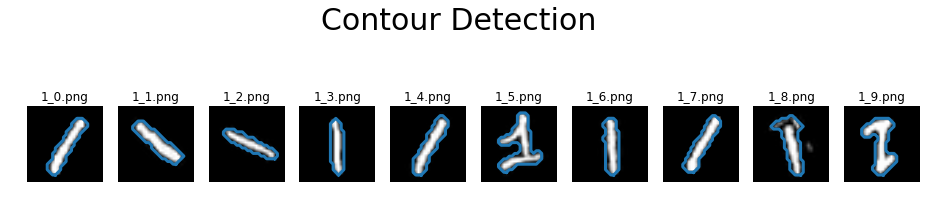

In [37]:
from skimage.transform import rotate

#############################################
# Rotate a subset of the images
#############################################

# Specify the images to be rotated. 
zeros_rotation = [0, 0, 0, 0, 3, 6, 40, 0, 30, 90]
ones_rotation = [0, 40, 60, 0, 3, 6, 10, 0, 30, 180]

# Rotate a subset of the zeros.
zeros_rotated = np.empty(zeros_im.shape)
for i in range(0, zeros_im.shape[0]): 
    zeros_rotated[i] = rotate(zeros_im[i], zeros_rotation[i], order = 5) 
    
# Rotate a subset of the ones.
ones_rotated = np.empty(ones_im.shape)
for i in range(0, ones_im.shape[0]): 
    ones_rotated[i] = rotate(ones_im[i], ones_rotation[i], order = 5) 
    

#############################################
# Extract the features and plot in 2D
#############################################

# Extract the first and third fourier descriptors
descriptors_to_extract = [1, 3]

# Process the ones
zeros_fourier_descriptors = extract_fourier_descriptors(zeros_rotated, zeros_names, descriptors_to_extract, True)

# Process the zeros
ones_fourier_descriptors = extract_fourier_descriptors(ones_rotated, ones_names, descriptors_to_extract, True)
    
# Plot a 2D scatter plot of the first fourier descriptors 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Fourier Descriptors for the Rotated Ones and Zeros', fontsize=30)
axes.scatter(abs(zeros_fourier_descriptors[:,0]), abs(zeros_fourier_descriptors[:,1]), label="Zeros")
axes.scatter(abs(ones_fourier_descriptors[:,0]), abs(ones_fourier_descriptors[:,1]), label="Ones")
axes.legend()
plt.xlabel('First Fourier Descriptor')
plt.ylabel('Second Fourier Descriptor')
plt.show()

### 1.4 Fourier Descriptors Showing Translation Invariance

We can also show that the Fourier Descriptors are invariant to translation. That is, if the object in the image is displaced by some amount, we can still identify it. This is because the position-dependent information is encoded in the very first Fourier Descriptor, which is simply a constant number, because $k = 0$, meaning that according to the fourier transform formula, 

$f_i = \sum_{k=0}^{N-1}{u_k e^{\frac{-j2\pi k l}{N}}}$, 

$f_0 = u_0 e^{\frac{-j2\pi 0 l}{N}} = u_0$. 

By excluding this component in our analysis, our ability to distinguish characters is independent of the position of the character in the image. This is shown in the scatterplot below, where again we have the same distribution of points as above.

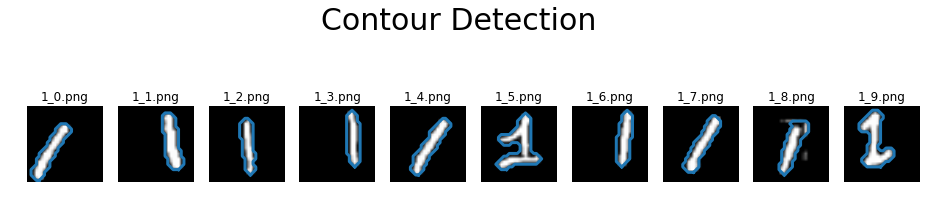

In [38]:
from skimage.transform import warp
from skimage.transform import SimilarityTransform

#############################################
# Translate a subset of the images
#############################################

# Specify the translation of each image. Translations are defined by tuples specifying the shift along the x & y axes.
zeros_translation = [(0,0), (0,0), (0,0), (5,1), (3,-3), (0,0), (0,0), (-2,3), (0,0), (0,0)]
ones_translation = [(6,-2), (-5,1), (0,0), (-6,3), (0,0), (0,0), (-5,3),(0,0), (0,0), (3,1)]

# Translate a subset of the zeros.
zeros_translated = np.empty(zeros_im.shape)
for i in range(0, zeros_im.shape[0]):
    tform = SimilarityTransform(translation=zeros_translation[i])
    zeros_translated[i] = warp(zeros_im[i], tform) 
    
# Translat a subset of the ones.
ones_translated = np.empty(ones_im.shape)
for i in range(0, ones_im.shape[0]): 
    tform = SimilarityTransform(translation= ones_translation[i])
    ones_translated[i] = warp(ones_im[i], tform)
    

#############################################
# Extract the features and plot in 2D
#############################################

# Extract the first and third fourier descriptors
descriptors_to_extract = [1, 3]

# Process the ones
zeros_fourier_descriptors = extract_fourier_descriptors(zeros_translated, zeros_names, descriptors_to_extract, True)

# Process the zeros
ones_fourier_descriptors = extract_fourier_descriptors(ones_translated, ones_names, descriptors_to_extract, True)  

    
# Plot a 2D scatter plot of the first fourier descriptors 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Fourier Descriptors for the Translated Ones and Zeros', fontsize=30)
axes.scatter(abs(zeros_fourier_descriptors[:,0]), abs(zeros_fourier_descriptors[:,1]), label="Zeros")
axes.scatter(abs(ones_fourier_descriptors[:,0]), abs(ones_fourier_descriptors[:,1]), label="Ones")
axes.legend()
plt.xlabel('First Fourier Descriptor')
plt.ylabel('Second Fourier Descriptor')
plt.show()

### 1.5 Using the Distances Between Contours as Features

To calculate the distance between the contours, we first needed to compute a distance map from a single reference image. To do this, we added an error value of 3 for every step adjacent to the contour pixel, and an error of 4 for every diagonal step. After creating a distance map each for the class '0' and '1' based on representative images, we compared all the '0' images to the '0' map and all the '1' images to the '1' map to get the intra class distance. For a second feature, we calculated the cross class distance by comparing all the '0' images to the '1' map, and vice versa. (WHY ARE THEY NOT THE SAME?)

Unlike the Fourier Descriptors, this method is dependent upon translation and orientation, as a modified figure can produce a very large error, even for identical shapes. In our case, this was not a problem, so we didn't implement any correction, as we would have needed to find some kind of optimization to get every pair of images as similar as possible, which would drastically increase computation time. However, performing this would likely also have the effect of reducing intra class distance.

In [39]:
#############################################
# Define a function that computes a distance map for the reference image
#############################################

def compute_distance_map(ref_image):
    
    # Variabels for the coordinates of pixels to sweep through.
    x_coordinate = 0
    y_coordinate = 0
    
    # Allocate a 2D array for the distance map. Initialize the elements to a large number.
    distance_map = np.full(ref_image.shape, 99999)
   
    # First find the contours of the reference image. Contours are represented by an array of coordinates (x, y)
    contour = detect_contour(ref_image)
    

    # For each pixel in the reference image, search for the min distance between the current pixel and the contour 
    for x_coordinate in range(0, ref_image.shape[0]):
        
        for y_coordinate in range(0, ref_image.shape[1]):
            
            # For each new coordinate, initialize the distance to 0
            distance = 0
            
            # Compute the distance between the current pixel and every pixel in the contour
            for pixel_position in contour:
                
                distance = np.square(x_coordinate - pixel_position[0]) + np.square(y_coordinate - pixel_position[1])
                
                # Update the distance map if a closer distance is found.
                if distance < distance_map[x_coordinate][y_coordinate]:
                    distance_map[x_coordinate][y_coordinate] = distance
        
    return distance_map

#############################################
# Define a function to extract the distance between contours for a list of images. 
#############################################

def compute_contour_distance(images, distance_map): # does this account for positioning?
    
    # The distances for each image.
    distances = []
    
    # Compute the distance for each image
    for im in images:
        
        # Find the contour for the current image
        contour = detect_contour(im)
        
        # Initialize the distance of each image to 0
        distance = 0

        # Compute the distance between the current image and the reference
        for pixel in contour:
            
            distance = distance + distance_map[int(pixel[0])][int(pixel[1])]
        
        # Append the computed distance
        distances.append(distance)
                
    return distances


#############################################
# Extract the features and plot in 2D
#############################################

# The reference image to take
ref = 5

# Compute the distance maps for the reference images.
zeros_distance_map = compute_distance_map(zeros_im[ref])
ones_distance_map = compute_distance_map(ones_im[ref])

# Compute the distances for the zeros and ones
intra_zeros_distances = compute_contour_distance(zeros_im, zeros_distance_map)
intra_ones_distances = compute_contour_distance(ones_im, ones_distance_map)

# Compute the distances between zeros and ones
zeros_cross_distances = compute_contour_distance(zeros_im, ones_distance_map)
ones_cross_distances = compute_contour_distance(ones_im, zeros_distance_map)

# Pop out the values for the reference images since they will both have a zero intra-class contour distance.
intra_zeros_distances = np.delete(intra_zeros_distances, ref)
intra_ones_distances = np.delete(intra_ones_distances, ref)
zeros_cross_distances = np.delete(zeros_cross_distances, ref)
ones_cross_distances = np.delete(ones_cross_distances, ref)

# Plot a 2D scatter plot of the intra number distances vs the cross number distances 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Features Based on Contour Distances for Ones and Zeros', fontsize=30)
axes.scatter(intra_zeros_distances, zeros_cross_distances, label="Zeros")
axes.scatter(intra_ones_distances, ones_cross_distances, label="Ones")
axes.legend()
plt.xlabel('Internal Contour Distance')
plt.ylabel('Cross Contour Distance')
plt.show()

### 1.6 Using the Edition Distances as Features

Another interesting feature that we extracted was the edition distance. The edition distance is a measure of the minimum number of edits needed to go from one Freeman code to another. A Freeman code is a lossless representation of an image's contour using a string of numbers that represent the direction of the next point on the contour relative to the current point. The Freeman code used in this implementation was:

* Move right : 0
* Move up and right : 1
* Move up : 2
* Move up and left : 3
* Move left : 4
* Move down and left : 5
* Move down : 6
* Move down and right : 7

There exists an effective algorithm for determining the minimum number of edits separating two strings, called the Fisher Wagner Algorithm. Neither of these reference images were included, as their intra class distance would be zero, and their cross class distance would be identical to each other.

The features that were extracted for each image class were the intra-class edition distances and the cross-class edition distances. The intra-class distances were defined as the edition distances between the images of a given class, and a reference image from that same class. The cross-class edition distances were defined as those between the images of a class and a reference from the *other* class. 

The edition distance appears to be quite effective at discriminating between the zeros and the ones, as almost all of the zeros have a value below 30 on the y axis, while the ones all have values above this. Notably, the ones appear to have a greater variance, and there are two points in the top right that are particularly distinct from the others.

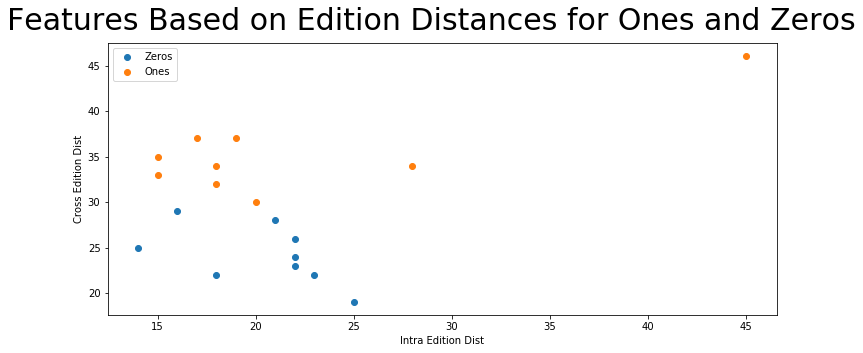

In [40]:
#############################################
# Define a function to determine the freeman code for each image in a class 
#############################################
def freeman_code(images):
    
    # The freeman codes for the set of images
    freeman_codes = []
    
    for im in images:        
        
        # The code for the current image
        current_code = []
        
        # Find the contour for the current image
        contour = detect_contour(im)
        
        # Walk along the contour and determine the freeman code.
        for i in range(0, contour.shape[0]):
            
            # Compute the angle between the two consecutive pixel coordinates.
            current_pixel = contour[i]
            if i == contour.shape[0]-1:
                final_pixel = contour[0]
            
            else:
                final_pixel = contour[i+1]
                
            # Build the freeman code 
            if np.array_equal(final_pixel, np.add(current_pixel, [1,0])): 
                current_code.append(0)
                    
            elif np.array_equal(final_pixel, np.add(current_pixel, [1,1])):
                current_code.append(1)

            elif np.array_equal(final_pixel, np.add(current_pixel, [0,1])):
                current_code.append(2)                
                
            elif np.array_equal(final_pixel, np.add(current_pixel, [-1,1])):
                current_code.append(3)            
            
            elif np.array_equal(final_pixel, np.add(current_pixel, [-1,0])):
                current_code.append(4)
                
            elif np.array_equal(final_pixel, np.add(current_pixel, [-1,-1])):
                current_code.append(5)

            elif np.array_equal(final_pixel, np.add(current_pixel, [0,-1])):
                current_code.append(6)
                
            elif np.array_equal(final_pixel, np.add(current_pixel, [1,-1])):
                current_code.append(7)
 
        # Store the completed code for the current image.
        freeman_codes.append(current_code)
    
    # Return the list of freeman codes
    return freeman_codes

#############################################
# Define a function to perform the Fisher-Wagner algorithm on two different freemen codes
#############################################
def fisher_wagner(image_freeman, reference_freeman):
    
    # Create the table that we will use to perform the fisher-wagner algorithm.
    fw_table = np.zeros((len(image_freeman), len(reference_freeman)))
    
    # First determine the distance of any first string to an empty second string
    for i in range(0, len(image_freeman)):
        fw_table[i,0] = i 
        
    for i in range(0, len(reference_freeman)):
        fw_table[0,i] = i 
    
    # Fill the rest of the table
    for j in range(1, len(reference_freeman)):
        
        for i in range(1, len(image_freeman)):
            
            if image_freeman[i] == reference_freeman[j]:
                
                # The codes match at this index, so no operation required
                fw_table[i][j] = fw_table[i-1][j-1]
                
            else:
                # The distance cost due to an deletion
                deletion = fw_table[i-1, j] + 1
            
                # The distance cost due to an insertion
                insertion = fw_table[i, j-1] + 1  

                # The distance cost due to an substitution
                substitution = fw_table[i-1, j-1] + 1 
            
                # The current position of the table becomes the minimum of these three possible operations
                fw_table[i][j] = np.amin([deletion, insertion, substitution])
            
    # The edition distance is the bottom-right value of this table
    return fw_table[-1][-1]

    
#############################################
# Define a function to extract minimum edition distance for each number with respect to a given image 
#############################################
def edition_distances(class_freeman_codes, reference_freeman):
    
    # The distances for each image.
    edition_distances = np.empty((len(class_freeman_codes),1))
    
    for i in range(0, len(class_freeman_codes)):
        
        # Determine the freemand code for the current image
        current_freeman = class_freeman_codes[i]
        
        # Compute the edition distance between image's freemand code and the reference freemand code via fisher-wagner.
        edition_distance = fisher_wagner(current_freeman, reference_freeman)
        
        # Update the vector of edition distances.
        edition_distances[i] = edition_distance
    
    return edition_distances


#############################################
# Extract the features and plot in 2D
#############################################

# Determine the freeman codes
freeman_codes_zeros = freeman_code(zeros_im)
freeman_codes_ones = freeman_code(ones_im)

# The reference image to take
ref = 8

# Compute the edition distance intra-class
intra_edition_distances_zeros = edition_distances(freeman_codes_zeros, freeman_codes_zeros[ref])
intra_edition_distances_ones = edition_distances(freeman_codes_ones, freeman_codes_ones[ref])

# Compute the edition distance cross-class
cross_edition_distances_zeros = edition_distances(freeman_codes_zeros, freeman_codes_ones[ref])
cross_edition_distances_ones = edition_distances(freeman_codes_ones, freeman_codes_zeros[ref])

# Pop out the values for the reference images since they will both have a zero intra-class edition distance.
intra_edition_distances_zeros = np.delete(intra_edition_distances_zeros, ref)
intra_edition_distances_ones = np.delete(intra_edition_distances_ones, ref)
cross_edition_distances_zeros = np.delete(cross_edition_distances_zeros, ref)
cross_edition_distances_ones = np.delete(cross_edition_distances_ones, ref)

# Plot a 2D scatter plot of the intra number distances vs the cross number distances 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Features Based on Edition Distances for Ones and Zeros', fontsize=30)
axes.scatter(intra_edition_distances_zeros, cross_edition_distances_zeros, label="Zeros")
axes.scatter(intra_edition_distances_ones, cross_edition_distances_ones, label="Ones")
axes.legend()
plt.xlabel('Intra Edition Dist')
plt.ylabel('Cross Edition Dist')
plt.show()

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 1.1 Data visualization

In [28]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
To distinguish 2s from 3s we return to the method of Fourier Descriptors. Notice, though, that 2 and 3 as characters are much more similar and more complex than are 0 and 1. We suspect that it is for these reasons that the Fourier Descriptors are less able to distinguish the two classes. Clearly, there is no single line that can divide the two classes, though this may be more distinguishable with more features.

Additionally, when looking at all four classes (0,1,2, and 3), these two features are not sufficient to separate all of them. Notably, though, 0 is fairly well separated from 1, 2 (worst), and 3. 1 is separated from 3 reasonably, but hopelessly tangles with 2.

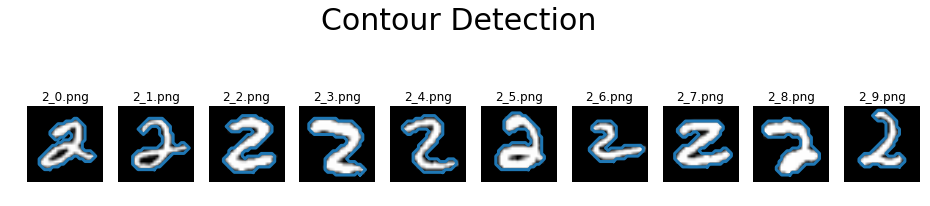

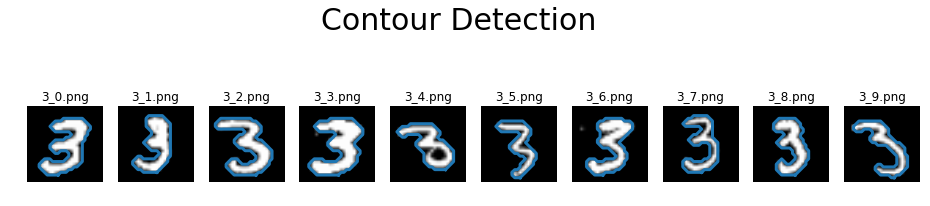

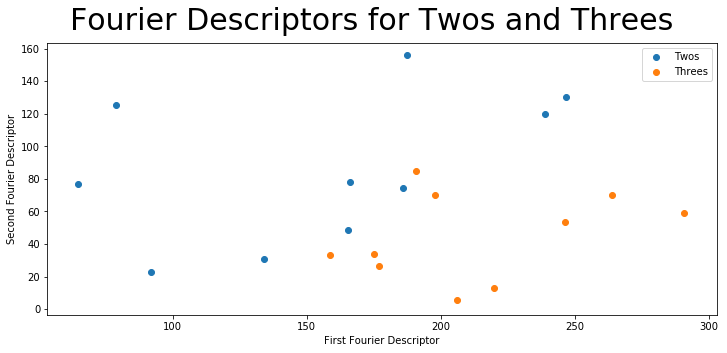

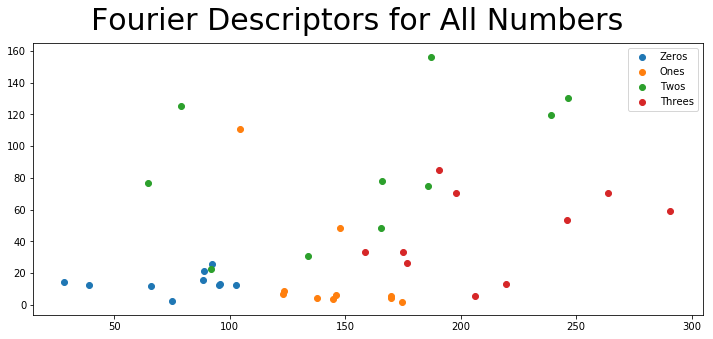

In [29]:
from skimage.morphology import binary_closing
from skimage.morphology import dilation
from skimage.morphology import erosion
from skimage.filters import median
from skimage.feature import canny
from mpl_toolkits.mplot3d import Axes3D

#############################################
# Extract the features and plot in 2D
#############################################

# Extract the first and third fourier descriptors
descriptors_to_extract = [1,3]

# Process the zeros
zeros_fourier_descriptors = extract_fourier_descriptors(zeros_im, zeros_names, descriptors_to_extract, False)

# Process the ones
ones_fourier_descriptors = extract_fourier_descriptors(ones_im, ones_names, descriptors_to_extract, False)

# Process the twos
twos_fourier_descriptors = extract_fourier_descriptors(twos_im, twos_names, descriptors_to_extract, True)

# Process the threes
threes_fourier_descriptors = extract_fourier_descriptors(threes_im, threes_names, descriptors_to_extract, True) 
    
# Plot a 2D scatter plot of the first fourier descriptors 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Fourier Descriptors for Twos and Threes', fontsize=30)
axes.scatter(abs(twos_fourier_descriptors[:,0]), abs(twos_fourier_descriptors[:,1]), label="Twos")
axes.scatter(abs(threes_fourier_descriptors[:,0]), abs(threes_fourier_descriptors[:,1]), label="Threes")
axes.legend()
plt.xlabel('First Fourier Descriptor')
plt.ylabel('Second Fourier Descriptor')
plt.show()

# Plot a 2D scatter plot of the first fourier descriptors for all numbers
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Fourier Descriptors for All Numbers', fontsize=30)
axes.scatter(abs(zeros_fourier_descriptors[:,0]), abs(zeros_fourier_descriptors[:,1]), label="Zeros")
axes.scatter(abs(ones_fourier_descriptors[:,0]), abs(ones_fourier_descriptors[:,1]), label="Ones")
axes.scatter(abs(twos_fourier_descriptors[:,0]), abs(twos_fourier_descriptors[:,1]), label="Twos")
axes.scatter(abs(threes_fourier_descriptors[:,0]), abs(threes_fourier_descriptors[:,1]), label="Threes")
axes.legend()
#plt.xlabel('First Fourier Descriptor')
#plt.ylabel('Second Fourier Descriptor')
plt.show()

### 1.3 Distances Between Contours

This method proved to be more effective at separating the 2s from the 3s, and also separated the 0s and the 1s fairly well. While this is definitely a marked improvement, it does not quite suffice in separating all four from each other, as there are still other overlaps. Still, if we implemented more features, this could possibly be the most effective way to distinguish the different classes.

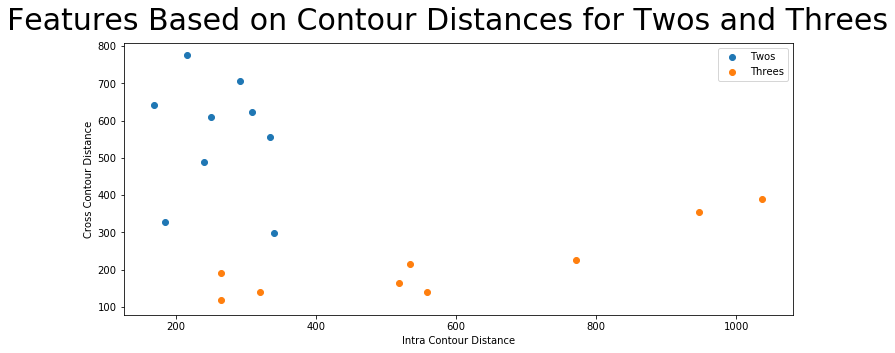

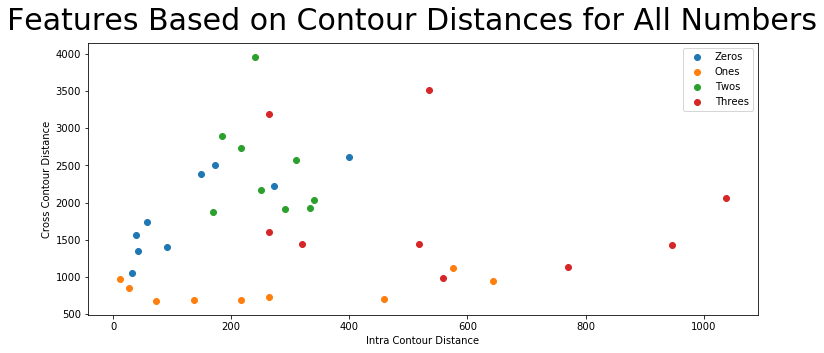

In [16]:
#############################################
# Extract the features and plot in 2D
#############################################

# The reference image to take
ref = 4

# Compute the distance maps for the reference images.
zeros_distance_map = compute_distance_map(zeros_im[ref])
ones_distance_map = compute_distance_map(ones_im[ref])
twos_distance_map = compute_distance_map(twos_im[ref])
threes_distance_map = compute_distance_map(threes_im[ref])

# Compute the distances for the twos and threes
#intra_zeros_distances = compute_contour_distance(zeros_im, zeros_distance_map)
#intra_ones_distances = compute_contour_distance(ones_im, ones_distance_map)
intra_twos_distances = compute_contour_distance(twos_im, twos_distance_map)
intra_threes_distances = compute_contour_distance(threes_im, threes_distance_map)

# Compute the cross distances between just the twos and the thres
twos_cross_distances = compute_contour_distance(twos_im, threes_distance_map)
threes_cross_distances = compute_contour_distance(threes_im, twos_distance_map)

# Pop out the values for the reference images since they will all have a zero intra-class contour distance.
intra_twos_distances = np.delete(intra_twos_distances, ref)
intra_threes_distances = np.delete(intra_threes_distances, ref)

twos_cross_distances = np.delete(twos_cross_distances, ref)
threes_cross_distances = np.delete(threes_cross_distances, ref)

# Plot a 2D scatter plot of the intra number distances vs the cross number distances 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Features Based on Contour Distances for Twos and Threes', fontsize=30)
axes.scatter(intra_twos_distances, twos_cross_distances, label="Twos")
axes.scatter(intra_threes_distances, threes_cross_distances, label="Threes")
axes.legend()
plt.xlabel('Intra Contour Distance')
plt.ylabel('Cross Contour Distance')
plt.show()

# Compute the distances for all numbers
intra_zeros_distances = compute_contour_distance(zeros_im, zeros_distance_map)
intra_ones_distances = compute_contour_distance(ones_im, ones_distance_map)
intra_twos_distances = compute_contour_distance(twos_im, twos_distance_map)
intra_threes_distances = compute_contour_distance(threes_im, threes_distance_map)

# Compute the distances between a number and all other classes of numbers
zeros_cross_distances = np.add(compute_contour_distance(zeros_im, ones_distance_map), 
                               compute_contour_distance(zeros_im, twos_distance_map))
zeros_cross_distances = np.add(zeros_cross_distances,
                              compute_contour_distance(zeros_im, threes_distance_map))

        
ones_cross_distances = np.add(compute_contour_distance(ones_im, zeros_distance_map),
                              compute_contour_distance(ones_im, twos_distance_map))
ones_cross_distances = np.add(ones_cross_distances,
                              compute_contour_distance(ones_im, threes_distance_map))

        
twos_cross_distances = np.add(compute_contour_distance(twos_im, zeros_distance_map),
                              compute_contour_distance(twos_im, ones_distance_map))
twos_cross_distances = np.add(twos_cross_distances,
                              compute_contour_distance(twos_im, threes_distance_map))


threes_cross_distances = np.add(compute_contour_distance(threes_im, zeros_distance_map),
                                compute_contour_distance(threes_im, ones_distance_map))
threes_cross_distances = np.add(threes_cross_distances,
                                compute_contour_distance(threes_im, twos_distance_map))

# Pop out the values for the reference images since they will all have a zero intra-class contour distance.
zeros_cross_distances = np.delete(zeros_cross_distances, ref)
ones_cross_distances = np.delete(ones_cross_distances, ref)
twos_cross_distances = np.delete(twos_cross_distances, ref)
threes_cross_distances = np.delete(threes_cross_distances, ref)

intra_zeros_distances = np.delete(intra_zeros_distances, ref)
intra_ones_distances = np.delete(intra_ones_distances, ref)
intra_twos_distances = np.delete(intra_twos_distances, ref)
intra_threes_distances = np.delete(intra_threes_distances, ref)

# Plot a 2D scatter plot of the intra number distances vs the cross number distances 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Features Based on Contour Distances for All Numbers', fontsize=30)
axes.scatter(intra_zeros_distances, zeros_cross_distances, label="Zeros")
axes.scatter(intra_ones_distances, ones_cross_distances, label="Ones")
axes.scatter(intra_twos_distances, twos_cross_distances, label="Twos")
axes.scatter(intra_threes_distances, threes_cross_distances, label="Threes")
axes.legend()
plt.xlabel('Intra Contour Distance')
plt.ylabel('Cross Contour Distance')
plt.show()

### 1.4 Edition Distances 


Using Edition distance, we *were* also able to separate the two classes, but not as well as with the contour distance. Note in particular how many of the 3s are clustered very near to the likely border between the two classes. This might suggest that with larger samples there could be a substantial amount of overlap with this technique. However, as with the other techniques, they may be more separable with a greater number of features. It also does not appear to perform very well when comparing all four classes, as (aside from 0 and 1) no two classes are linearly separable, even allowing for a single error.

For both the Contour Distances and the Edition distances, it should be noted that a key consideration is the choice of reference image. We may be able to achieve better results by selecting a better reference image than what was made available in the current 10 images per class.

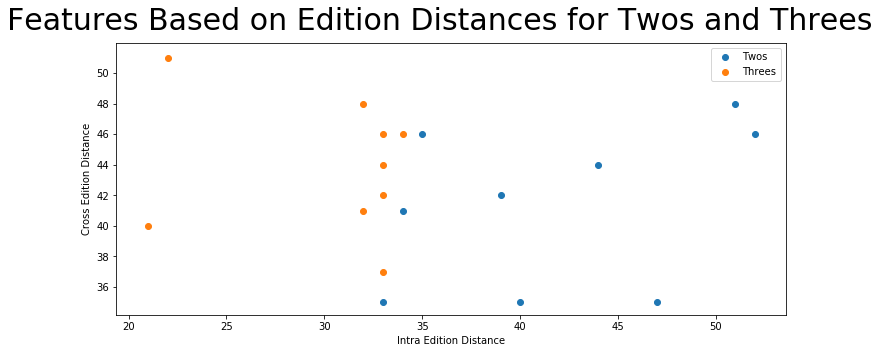

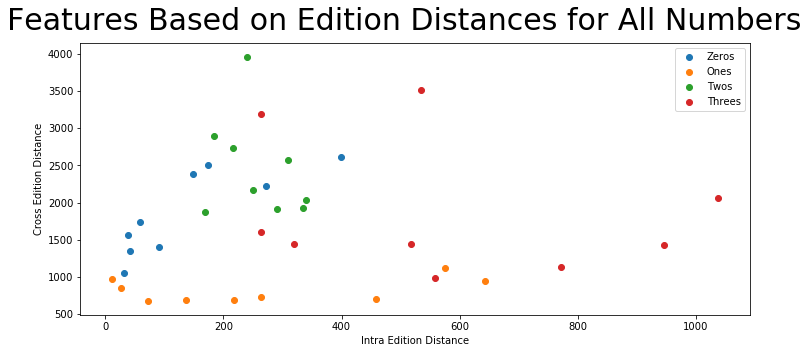

In [17]:
#############################################
# Extract the features and plot in 2D
#############################################

# Determine the freeman codes
freeman_codes_zeros = freeman_code(zeros_im)
freeman_codes_ones = freeman_code(ones_im)
freeman_codes_twos = freeman_code(twos_im)
freeman_codes_threes = freeman_code(threes_im)

# The reference image to take
ref = 3

# Compute the edition distance intra-class
intra_edition_distances_twos = edition_distances(freeman_codes_twos, freeman_codes_twos[ref])
intra_edition_distances_threes = edition_distances(freeman_codes_threes, freeman_codes_threes[ref])

# Compute the edition distance cross-class
cross_edition_distances_twos = edition_distances(freeman_codes_twos, freeman_codes_threes[ref])
cross_edition_distances_threes = edition_distances(freeman_codes_threes, freeman_codes_twos[ref])

# Pop out the values for the reference images since they will both have a zero intra-class edition distance.
intra_edition_distances_twos = np.delete(intra_edition_distances_twos, ref)
intra_edition_distances_threes = np.delete(intra_edition_distances_threes, ref)
cross_edition_distances_twos = np.delete(cross_edition_distances_twos, ref)
cross_edition_distances_threes = np.delete(cross_edition_distances_threes, ref)

# Plot a 2D scatter plot of the intra number distances vs the cross number distances 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Features Based on Edition Distances for Twos and Threes', fontsize=30)
axes.scatter(intra_edition_distances_twos, cross_edition_distances_twos, label="Twos")
axes.scatter(intra_edition_distances_threes, cross_edition_distances_threes, label="Threes")
axes.legend()
plt.xlabel('Intra Edition Distance')
plt.ylabel('Cross Edition Distance')
plt.show()

# Compute the edition distance intra-class
intra_edition_distances_zeros = edition_distances(freeman_codes_zeros, freeman_codes_zeros[ref])
intra_edition_distances_ones = edition_distances(freeman_codes_ones, freeman_codes_ones[ref])
intra_edition_distances_twos = edition_distances(freeman_codes_twos, freeman_codes_twos[ref])
intra_edition_distances_threes = edition_distances(freeman_codes_threes, freeman_codes_threes[ref])

# Compute the edition distances between a number and all other classes of numbers
cross_edition_distances_zeros = np.add(edition_distances(freeman_codes_zeros, freeman_codes_ones[ref]), 
                               edition_distances(freeman_codes_zeros, freeman_codes_twos[ref]))
cross_edition_distances_zeros = np.add(cross_edition_distances_zeros,
                              edition_distances(freeman_codes_zeros, freeman_codes_threes[ref]))

cross_edition_distances_ones = np.add(edition_distances(freeman_codes_ones, freeman_codes_zeros[ref]), 
                               edition_distances(freeman_codes_ones, freeman_codes_twos[ref]))
cross_edition_distances_ones = np.add(cross_edition_distances_zeros,
                              edition_distances(freeman_codes_ones, freeman_codes_threes[ref]))     

cross_edition_distances_twos = np.add(edition_distances(freeman_codes_twos, freeman_codes_ones[ref]), 
                               edition_distances(freeman_codes_twos, freeman_codes_zeros[ref]))
cross_edition_distances_twos = np.add(cross_edition_distances_twos,
                              edition_distances(freeman_codes_twos, freeman_codes_threes[ref]))

cross_edition_distances_threes = np.add(edition_distances(freeman_codes_threes, freeman_codes_ones[ref]), 
                               edition_distances(freeman_codes_threes, freeman_codes_twos[ref]))
cross_edition_distances_threes = np.add(cross_edition_distances_threes,
                              edition_distances(freeman_codes_threes, freeman_codes_threes[ref]))

# Pop out the values for the reference images since they will all have a zero intra-class edition distance.
cross_edition_distances_zeros = np.delete(cross_edition_distances_zeros, ref)
cross_edition_distances_ones = np.delete(cross_edition_distances_ones, ref)
cross_edition_distances_twos = np.delete(cross_edition_distances_twos, ref)
cross_edition_distances_threes = np.delete(cross_edition_distances_threes, ref)

intra_edition_distances_zeros = np.delete(intra_zeros_distances, ref)
intra_edition_distances_ones = np.delete(intra_ones_distances, ref)
intra_edition_distances_twos = np.delete(intra_twos_distances, ref)
intra_edition_distances_threes = np.delete(intra_threes_distances, ref)

# Plot a 2D scatter plot of the intra number distances vs the cross number distances 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Features Based on Edition Distances for All Numbers', fontsize=30)
axes.scatter(intra_zeros_distances, zeros_cross_distances, label="Zeros")
axes.scatter(intra_ones_distances, ones_cross_distances, label="Ones")
axes.scatter(intra_twos_distances, twos_cross_distances, label="Twos")
axes.scatter(intra_threes_distances, threes_cross_distances, label="Threes")
axes.legend()
plt.xlabel('Intra Edition Distance')
plt.ylabel('Cross Edition Distance')
plt.show()